In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.svm import SVC


In [2]:
filename = '../../legacy/EPL_Dataset/Final_Data.csv'
data = pd.read_csv(filename)

print(data.columns)

# Label Encoding
label_encoder = LabelEncoder()
data['FTR'] = label_encoder.fit_transform(data['FTR'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

# Feature Selection
X = data.drop(columns=['Season', 'Home', 'Away', 'FTR', 'Time_Weight', 'Text'])  # Drop unnecessary columns
y = data['FTR']

# Train-Validation-Test Split based on time
train_split = int(len(X) * 0.7)
val_split = int(len(X) * 0.85)

X_train, X_val, X_test = X.iloc[:train_split], X.iloc[train_split:val_split], X.iloc[val_split:]
y_train, y_val, y_test = y.iloc[:train_split], y.iloc[train_split:val_split], y.iloc[val_split:]

random_state = 40
val_acc = []
test_acc = []

Index(['MatchID', 'Season', 'Home', 'Away', 'FTR', 'HomeTeam_WinPercentage',
       'HomeTeam_DrawPercentage', 'AwayTeam_WinPercentage',
       'AwayTeam_DrawPercentage', 'HomeTeam_Streak', 'AwayTeam_Streak',
       'HomeTeam_AvgGoal', 'AwayTeam_AvgGoal', 'HomeTeam_AvgGoalDiff',
       'AwayTeam_AvgGoalDiff', 'HomeTeam_AvgShotOnTarget',
       'AwayTeam_AvgShotOnTarget', 'HomeTeam_AvgShotBlock',
       'AwayTeam_AvgShotBlock', 'HomeTeam_AvgCorners', 'AwayTeam_AvgCorners',
       'HomeTeam_AvgRedCards', 'AwayTeam_AvgRedCards',
       'HomeTeam_AvgYellowCards', 'AwayTeam_AvgYellowCards',
       'HomeTeam_H2H_Wins', 'AwayTeam_H2H_Wins', 'HomeTeam_Last_Season',
       'AwayTeam_Last_Season', 'Time_Weight', 'Text'],
      dtype='object')
{'A': 0, 'D': 1, 'H': 2}


In [3]:
# SVM
svm_model = SVC(C=1, kernel='rbf', gamma='scale', random_state=random_state)
svm_model.fit(X_train, y_train)

y_val_pred = svm_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

y_test_pred = svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

val_acc.append(val_accuracy)
test_acc.append(test_accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_test_pred, average='weighted')
metrics_svm = [accuracy, recall, precision, f1]


Validation Accuracy: 0.46
Test Accuracy: 0.48


In [4]:
# XGB

alpha = 0.6
weights = alpha ** (1 - data['Time_Weight'])

model = xgb.XGBClassifier(objective='multi:softmax',
                          num_class=3,
                          n_estimators=100,
                          learning_rate=0.1,
                          max_depth=5,
                          random_state=random_state)


# Model Fitting on Training Set
model.fit(X_train, y_train, sample_weight=weights.loc[y_train.index].values)

y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')

val_acc.append(val_accuracy)
test_acc.append(test_accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
metrics_xgb = [accuracy, recall, precision, f1]

Validation Accuracy: 0.60
Test Accuracy: 0.57


In [5]:
# Random Forest
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=random_state
)

model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')

y_pred_rf = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Test Accuracy: {test_accuracy:.2f}')

val_acc.append(val_accuracy)
test_acc.append(test_accuracy)

accuracy = accuracy_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf, average='weighted')
precision = precision_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')
metrics_rf = [accuracy, recall, precision, f1]

                             

Validation Accuracy: 0.63
Test Accuracy: 0.57


In [6]:
# Logistic Regression
model = LogisticRegression(max_iter=2000, random_state=random_state)

model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')

val_acc.append(val_accuracy)
test_acc.append(test_accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
metrics_lr = [accuracy, recall, precision, f1]

Validation Accuracy: 0.62
Test Accuracy: 0.64


In [7]:
# Neural Network
# Convert pre-split datasets to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Neural Network Model Definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.softmax(self.fc3(x), dim=1)
        return x

# Model Initialization
input_size = X_train.shape[1]
num_classes = len(y_train.unique())
model = NeuralNetwork(input_size, num_classes)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Model
epochs = 200
val_accuracy_nn = 0
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_accuracy_nn = correct / total
    # print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, '
    #       f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}')

print(f'Validation Accuracy: {val_accuracy:.2f}')
# Evaluate the Model on Test Set
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor)
    y_pred_nn_classes = torch.argmax(y_pred_nn, axis=1).numpy()

# Test Accuracy
accuracy_nn = accuracy_score(y_test, y_pred_nn_classes)
print(f'Neural Network Test Accuracy: {accuracy_nn:.2f}')

val_acc.append(val_accuracy_nn)
test_acc.append(accuracy_nn)

accuracy = accuracy_score(y_test, y_pred_nn_classes)
recall = recall_score(y_test, y_pred_nn_classes, average='weighted')
precision = precision_score(y_test, y_pred_nn_classes, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_nn_classes, average='weighted')
metrics_nn = [accuracy, recall, precision, f1]

Validation Accuracy: 0.62
Neural Network Test Accuracy: 0.48


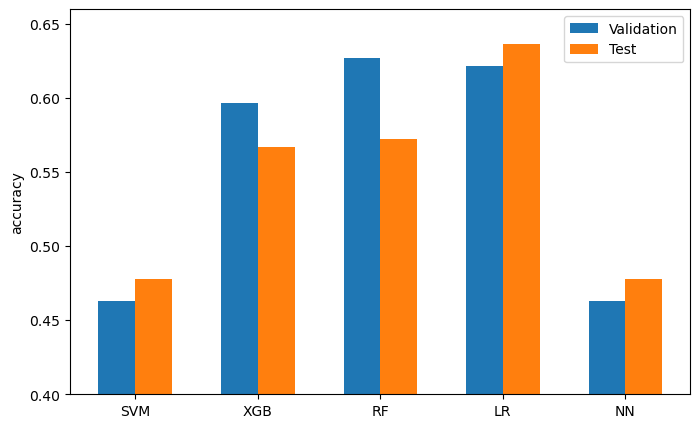

            0       1          2         3
     Accuracy  Recall  Precision  F1 Score
SVM     0.478   0.478      0.228     0.309
XGB     0.567   0.567      0.557     0.538
RF      0.572   0.572      0.553     0.522
LR      0.637   0.637      0.602      0.59
NN      0.478   0.478      0.228     0.309


In [17]:
# val_acc is the validation accuracy
# test_acc is the test accuracy
# metrics_df is the prediction metrics

methods = ["SVM", "XGB", "RF", "LR", "NN"]


bar_width = 0.3
x = np.arange(len(methods))

plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, val_acc, width=bar_width, label="Validation")
plt.bar(x + bar_width/2, test_acc, width=bar_width, label="Test")


plt.xlabel('')
plt.ylabel("accuracy")
#plt.title("Statistical Dataset Modeling")
plt.xticks(x, methods)
plt.legend()

plt.ylim(0.4, 0.66)

plt.show()

metrics = {
    '': ['Accuracy', 'Recall', 'Precision', 'F1 Score'],
    'SVM': [round(num, 3) for num in metrics_svm],
    'XGB': [round(num, 3) for num in metrics_xgb],
    'RF': [round(num, 3) for num in metrics_rf],
    'LR': [round(num, 3) for num in metrics_lr],
    'NN': [round(num, 3) for num in metrics_nn]

}
metrics_df = pd.DataFrame(metrics).T

print(metrics_df)


